In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats
import statistics

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import graphviz

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import statsmodels.api as sm

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from sklearn.metrics import f1_score


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=cd0a73baf3dcf19ecb3958355e3321b6cd6340605c472afeb7c395d3867623bc
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=706ff470f316f97ade59541cfadf68d1c9717539d8d78c6f48cf0b1de7fc98f0
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
  Preparing metadata (setup.py) ... done
  Created wheel for pypair: filename=pypair-3.0.9-py3-none-any.whl size=24526 sha256=66beb5ed7d2d03e84eb74e022c6390d16d59ffd79527ed14ce56bd68e746eb26
  Stored in directory: /root/.cache/pip/wheels/27/d8/78/bc27988fe8ef1086879ea558f8c9bc03d8c51e4ff2c1ee8344
Successfully built pypair
     ━━━━━━

In [2]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)



1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

In [3]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")

player_complexity['Experiment_score_max_5'] = player_complexity['Experiment_score_max_5'].round().astype(int)
player_complexity['Modeling_score_max_5'] = player_complexity['Modeling_score_max_5'].round().astype(int)
player_complexity['Argument_score_max_4'] = player_complexity['Argument_score_max_4'].round().astype(int)

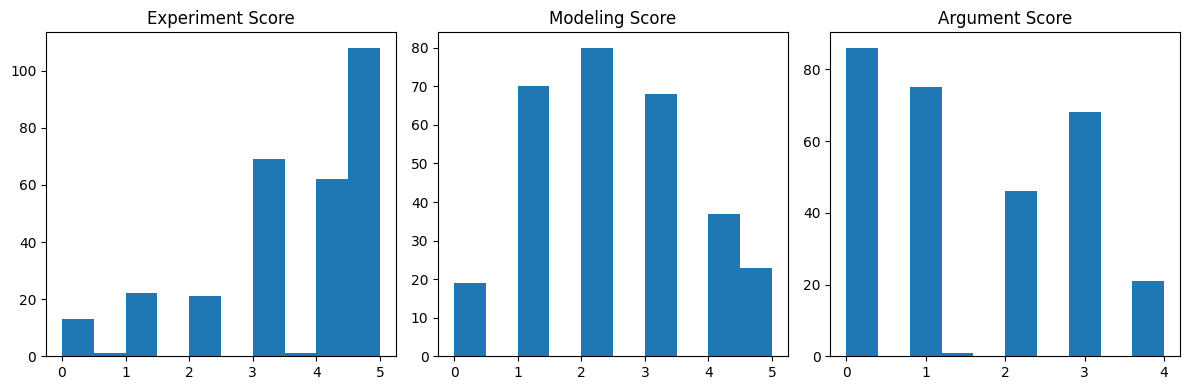

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [4]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

In [5]:
df = player_complexity

# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_2'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Experiment_score_max_5']) else 1)

####################
df['Modeling_score_max_5_binary_bucket_3'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 75) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_3'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 75) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_3'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 75) else 1)


########################
df['Modeling_score_max_5_bucket_4'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 25) else (1 if x < np.percentile(df['Modeling_score_max_5'], 50) else (2 if x < np.percentile(df['Modeling_score_max_5'], 75) else 3)))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_bucket_4'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 25) else (1 if x < np.percentile(df['Argument_score_max_4'], 50) else (2 if x < np.percentile(df['Argument_score_max_4'], 75) else 3)))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_bucket_4'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 25) else (1 if x < np.percentile(df['Experiment_score_max_5'], 50) else (2 if x < np.percentile(df['Experiment_score_max_5'], 75) else 3)))

<ipython-input-5-65277f1397e7>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)
<ipython-input-5-65277f1397e7>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)
<ipython-input-5-65277f1397e7>:10: PerformanceWarning: DataFrame is high

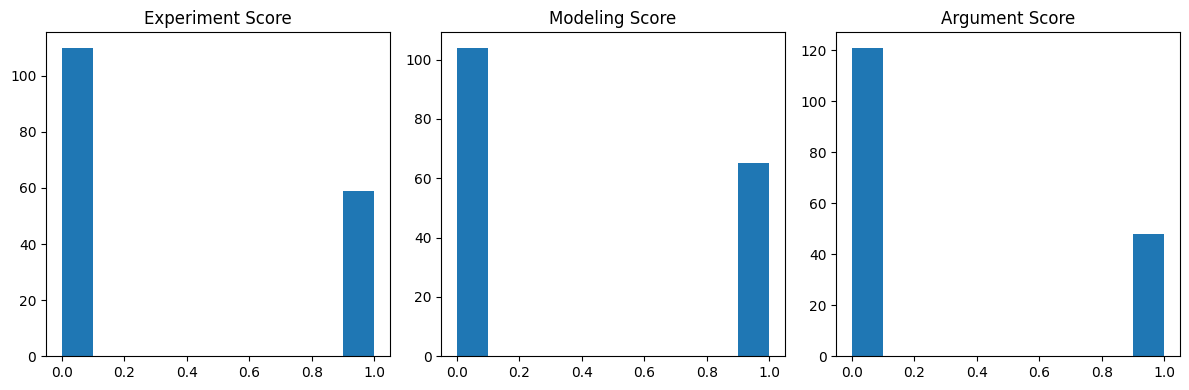

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [6]:
experiment_score = df['Experiment_score_max_5_binary_bucket_3']
modeling_score = df['Modeling_score_max_5_binary_bucket_3']
argument_score = df['Argument_score_max_4_binary_bucket_3']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

In [9]:
df_new = df

for job in df_new:
  if "TasksCompleted" in job:
    max = df_new[job].max()
    df_new[job] = df_new[job].apply(lambda x: x/df_new[job].max() if x !=0 and df_new[job].max() != 0 else x/100)

df_new[['job12_JobTasksCompleted']]




correlation_columns = ['Argument_score_max_4_binary_bucket_3']

i = 0
for job in df_new:
  if "TasksCompleted" in job:
    for corr in correlation_columns:
      i += 1
      pbs = stats.pointbiserialr(df_new[corr], df_new[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')
print(i)


job12_JobTasksCompleted: 0.22102996387056909, 0.003878612362366899, Argument_score_max_4_binary_bucket_3
job13_JobTasksCompleted: 0.28694893612833045, 0.00015525478511295868, Argument_score_max_4_binary_bucket_3
job32_JobTasksCompleted: 0.23033997432687828, 0.0025883663182104427, Argument_score_max_4_binary_bucket_3
57


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Optimization terminated successfully.
         Current function value: 0.575085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573414
         Iterations 5


Text(0, 0.5, 'Argument_score_max_4_binary_bucket_3')

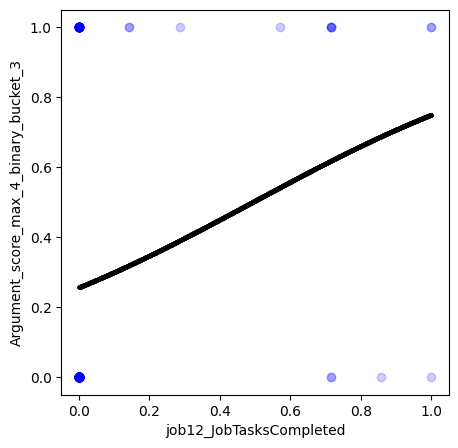

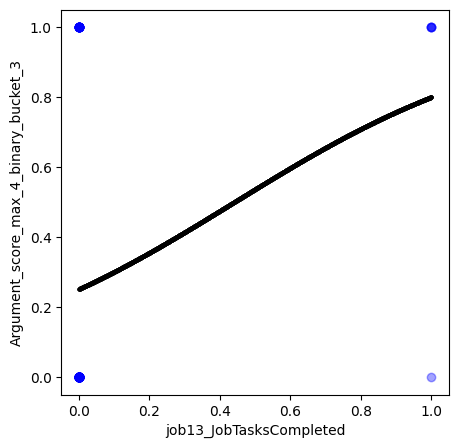

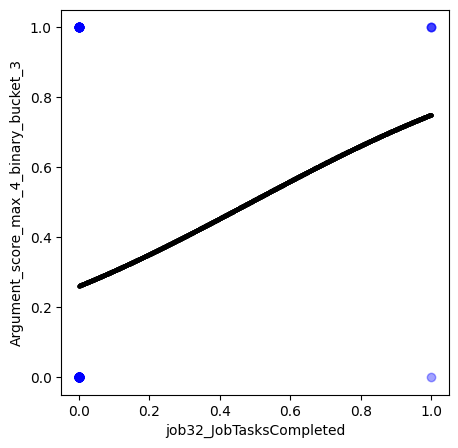

In [10]:
res = 'job12_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


########################



res = 'job13_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


########################


res = 'job32_JobTasksCompleted'
pred = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df_new).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df_new[res].min(), df_new[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df_new[res], df_new[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

## Decision Tree

In [99]:

X = df_new[['job13_JobTasksCompleted', 'job12_JobTasksCompleted', 'job32_JobTasksCompleted']]
y = df_new['Argument_score_max_4_binary_bucket_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)




In [100]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rf.score

Accuracy: 0.7647058823529411


<bound method ClassifierMixin.score of RandomForestClassifier()>

In [ ]:
for i in range(4):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


In [109]:
parameters_dict = {"max_depth": [2,5,6,10], "min_samples_split" : [0.1, 0.2, 0.3, 0.4], "min_samples_leaf" : [0.1, 0.2, 0.3, 0.4], "criterion": ["gini","entropy"]}

grid_obj = sklearn.model_selection.GridSearchCV(estimator=rf,param_grid=parameters_dict, cv=10)

grid_obj.fit(X_train,y_train)

#Extract the best classifier
best_clf = grid_obj.best_estimator_

In [194]:
from sklearn.metrics import classification_report

X = df_new[['job12_JobTasksCompleted','job13_JobTasksCompleted']]
y = df_new['Argument_score_max_4_binary_bucket_3'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

clf = LogisticRegression(random_state=0)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(classification_report(y_test, pred))

print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        59
           1       1.00      0.12      0.21        26

    accuracy                           0.73        85
   macro avg       0.86      0.56      0.52        85
weighted avg       0.81      0.73      0.64        85

[[59  0]
 [23  3]]


In [219]:

X = df[['job13_JobTasksCompleted']]
y = df_new['Argument_score_max_4_binary_bucket_3'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)


log_reg = sm.Logit(y_train, X_train).fit()

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.681606
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Logit Regression Results                                    
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   No. Observations:                  167
Model:                                            Logit   Df Residuals:                      166
Method:                                             MLE   Df Model:                            0
Date:                                  Tue, 01 Aug 2023   Pseudo R-squ.:                 -0.1469
Time:                                          15:34:01   Log-Likelihood:                -113.83
converged:                                         True   LL-Null:                       -99.249
Covariance Type:                              nonrobust   LLR p-value:                       nan
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     1.3863      0.791      1.754      0.080      -0.163       2.936
===========================================================================================
"""